In [27]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

In [28]:
import tensorflow as tf
import tf_keras as keras
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [29]:
from IPython.display import display, ProgressBar, update_display, Math
import time

In [4]:
import pathlib
import zipfile

In [5]:
SEG_TRAIN_DATA_URL = "/home/rayat69/Downloads/ISIC-images.zip"

seg_train_download_dir = 'datasets/skin_lesion/train'

In [ ]:
with zipfile.ZipFile(SEG_TRAIN_DATA_URL) as z:
    z.extractall(seg_train_download_dir + '/images')

In [6]:
seg_train_data_dir = pathlib.Path(seg_train_download_dir).with_suffix('')
# seg_train_data_dir = seg_train_data_dir / "Scabies Dataset"
print(seg_train_data_dir)

datasets/skin_lesion/train


In [49]:
def grabcut_generate_save(image_path: pathlib.Path, save_path: pathlib.Path) -> None:
    # Read the image
    path = pathlib.Path(image_path)
    saved_img_path = save_path / f"{os.path.basename(path)}"
    
    if os.path.isfile(saved_img_path) and os.path.exists(saved_img_path):
        return cv2.imread(saved_img_path, cv2.IMREAD_GRAYSCALE)
    
    
    image = cv2.imread(image_path)
    # print(image.shape)
    image = cv2.resize(image, (256, 256))  # Resize for consistency

    # Create an initial mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Define a rectangle for the region of interest
    rect = (10, 10, image.shape[1] - 20, image.shape[0] - 20)  # Adjust as needed

    # Models for background and foreground
    bg_model = np.zeros((1, 65), dtype=np.float64)
    fg_model = np.zeros((1, 65), dtype=np.float64)

    # Apply GrabCut algorithm
    cv2.grabCut(image, mask, rect, bg_model, fg_model, 5, cv2.GC_INIT_WITH_RECT)

    # Convert the mask to binary
    binary_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8") * 255

    # Save the mask
    cv2.imwrite(save_path / f"{os.path.basename(path)}", binary_mask)
    # cv2.imshow("image", image)
    # cv2.imshow("mask", binary_mask)
    
    return binary_mask

In [ ]:
np.random.seed(333)
selected_for_removal = np.random.choice(list(seg_train_data_dir.glob('images/*.jpg')), 1000)

size = len(selected_for_removal)

progress = ProgressBar(size)
progress.display()

for image_path in selected_for_removal:
    progress.progress += 1
    try:
        os.remove(os.path.realpath(image_path))
    except FileNotFoundError:
        continue

[                                                            ] 11/1000

In [46]:
selected_for_removal = None
segmentation_train_images = None

In [54]:
images_path = seg_train_data_dir.glob('images/*.jpg')

size = len(list(images_path))

progress = ProgressBar(size)
display(f"[0/{size}]==================================[0s remaining]",
        display_id="progress_time")
progress.display()
start = time.time()

for image in seg_train_data_dir.glob('images/*.jpg'):
    grabcut_generate_save(image, seg_train_data_dir / "masks")
    progress.progress += 1
    end = time.time()
    avg_speed = end - start
    remaining = size - progress.progress
    remaining_time = remaining * avg_speed
    formated_time = time.strftime("%H:%M:%S", time.gmtime(remaining_time))
    display(f"[{progress.progress}/{size}]==================================[{formated_time} remaining]",
            display_id="progress_time", update=True,)
    start = end
    # break

'[3679/3679]==================================[00:00:00 remaining]'

[                                                            ] 0/3679

In [7]:
BATCH_SIZE = 16
IMG_HEIGHT = 256
IMG_WIDTH = 256

IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [8]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [9]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = keras.layers.MaxPool2D(2)(f)
   p = keras.layers.Dropout(0.3)(p)

   return f, p

In [10]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = keras.layers.concatenate([x, conv_features])
   # dropout
   x = keras.layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [11]:
def build_unet(name: str = 'U-Net', input_shape: tuple[int, int, int] = IMG_SHAPE):
    # inputs
   inputs = keras.Input(shape=input_shape)

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = keras.layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = keras.Model(inputs, outputs, name=name)

   return unet_model

In [12]:
segmentation_train_images: tf.data.Dataset = keras.utils.image_dataset_from_directory(
    seg_train_data_dir / "images",
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=1337,
    shuffle=False
)

segmentation_train_masks: tf.data.Dataset = keras.utils.image_dataset_from_directory(
    seg_train_data_dir / "masks",
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=1337,
    shuffle=False,
    color_mode="grayscale"
)

Found 3679 files belonging to 1 classes.
Found 3679 files belonging to 1 classes.


I0000 00:00:1734765232.126698   23222 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1734765232.127808   23222 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4273 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
rescale = keras.layers.Rescaling(1.0 / 255)

In [14]:
segmentation_ds = tf.data.Dataset.zip(
    (segmentation_train_images, segmentation_train_masks,))
segmentation_ds = segmentation_ds.map(lambda x, y: (rescale(x), rescale(y)))
segmentation_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [15]:
ds_cardinality = tf.data.experimental.cardinality(segmentation_ds).numpy()

train_size = int(0.7 * ds_cardinality)
val_size = int(0.15 * ds_cardinality)
test_size = int(0.15 * ds_cardinality)

train_ds = segmentation_ds.take(train_size)
test_ds = segmentation_ds.skip(train_size)
val_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

segmentation_train_images = None
segmentation_train_masks = None
segmentation_ds = None

In [ ]:
for image_batch, mask_batch in train_ds.take(1):
    for i in range(3):
        plt.subplot(1, 2, 1)
        plt.imshow(image_batch[i])
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(tf.squeeze(mask_batch[i], axis=-1), cmap="gray")
        plt.axis("off")
        plt.show()

2024-12-21 13:13:07.250401: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 8589934592 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1734765187.250528   15572 device_host_allocator.h:61] could not allocate pinned host memory of size: 8589934592
2024-12-21 13:13:07.251287: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 7730940928 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1734765187.251389   15572 device_host_allocator.h:61] could not allocate pinned host memory of size: 7730940928
2024-12-21 13:13:07.251465: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 6957846528 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1734765187.251475   15572 device_host_allocator.h:61] could not allocate pinned host memory of size: 6957846528


In [16]:
unet_1 = build_unet(name="U-Net", input_shape=IMG_SHAPE)

In [17]:
unet_1.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [18]:
unet_1.build(input_shape=(None, *IMG_SHAPE))

In [19]:
LEARNING_RATE = 0.001

unet_1.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
               loss=keras.losses.SparseCategoricalCrossentropy(),
               metrics=["accuracy"])

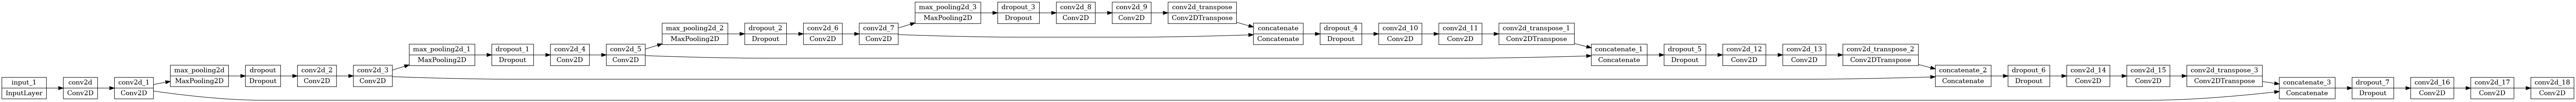

In [20]:
keras.utils.plot_model(unet_1, rankdir="LR")

In [21]:
NUM_EPOCHS = 50

history_1 = unet_1.fit(train_ds,
                       epochs=NUM_EPOCHS,
                       validation_data=val_ds,)

Epoch 1/50


E0000 00:00:1734765326.699146   23222 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1734765333.257406   29159 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-21 13:15:37.835451: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:359] gpu_async_0 cuMemAllocAsync failed to allocate 1829896192 bytes: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
 Reported by CUDA: Free memory/Total memory: 865927168/6219038720
2024-12-21 13:15:37.835495: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:364] Stats: Limit:                      4481417216
InUse:                      4849934309
MaxInUse:                   5672312821
NumAllocs:                         681
MaxAllocSize:               2583724048
Reserved:                            0
PeakReserved:                

161/161 [==============================] - 148s 737ms/step - loss: 0.6088 - accuracy: 0.6405 - val_loss: 0.5344 - val_accuracy: 0.7313
Epoch 2/50
161/161 [==============================] - 118s 730ms/step - loss: 0.3625 - accuracy: 0.8217 - val_loss: 0.3117 - val_accuracy: 0.8483
Epoch 3/50
161/161 [==============================] - 118s 731ms/step - loss: 0.3202 - accuracy: 0.8405 - val_loss: 0.3443 - val_accuracy: 0.8334
Epoch 4/50
161/161 [==============================] - 120s 743ms/step - loss: 0.3074 - accuracy: 0.8462 - val_loss: 0.3073 - val_accuracy: 0.8392
Epoch 5/50
161/161 [==============================] - 119s 742ms/step - loss: 0.3040 - accuracy: 0.8480 - val_loss: 0.3248 - val_accuracy: 0.8427
Epoch 6/50
161/161 [==============================] - 121s 750ms/step - loss: 0.3029 - accuracy: 0.8502 - val_loss: 0.2830 - val_accuracy: 0.8604
Epoch 7/50
161/161 [==============================] - 121s 752ms/step - loss: 0.2967 - accuracy: 0.8527 - val_loss: 0.2891 - val_accura

In [22]:
unet_1.save("models/skin_lesion_segmentation_unet_v2")

INFO:tensorflow:Assets written to: models/skin_lesion_segmentation_unet_v2/assets


INFO:tensorflow:Assets written to: models/skin_lesion_segmentation_unet_v2/assets


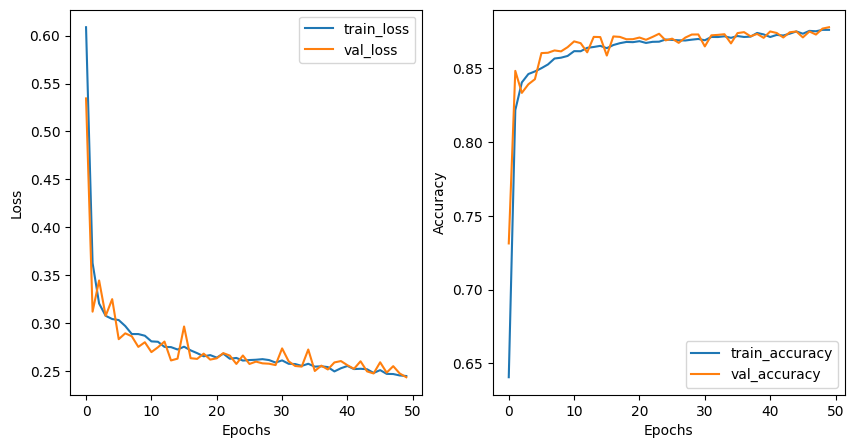

In [24]:
# plot the model results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_1.history["loss"], label="train_loss")
plt.plot(history_1.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1.history["accuracy"], label="train_accuracy")
plt.plot(history_1.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

2024-12-21 14:54:14.326086: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 0s 374ms/step


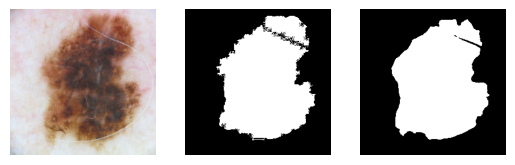

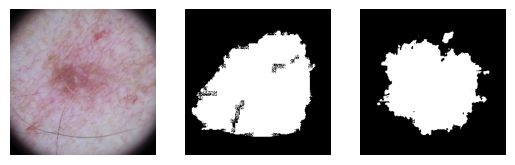

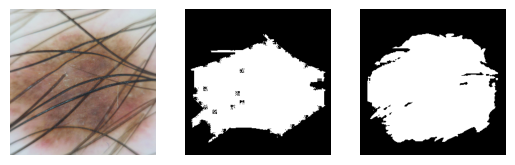

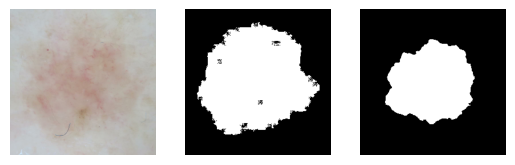

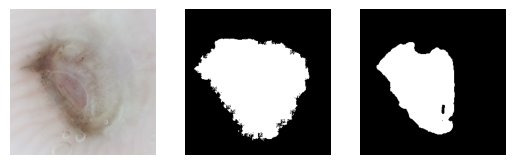

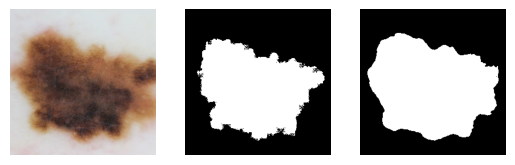

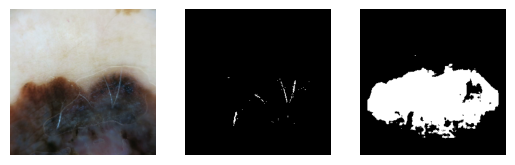

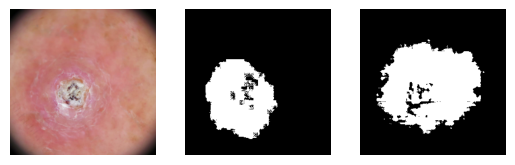

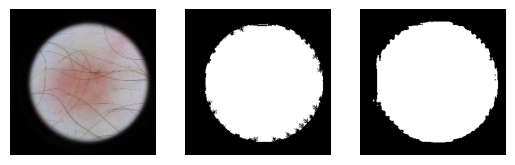

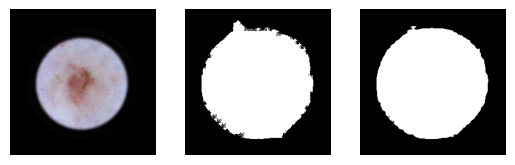

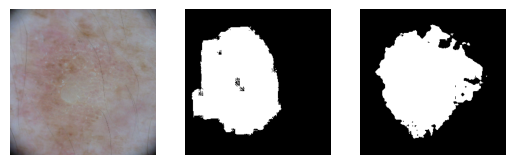

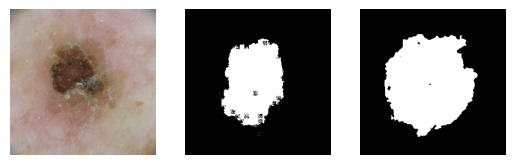

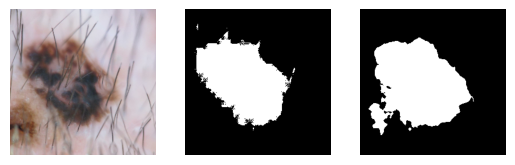

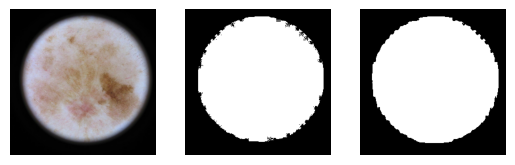

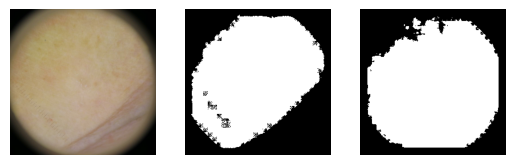

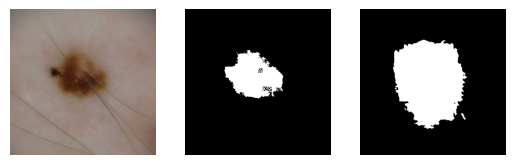

2024-12-21 14:54:16.959018: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 16 of dimension 0 out of bounds.
2024-12-21 14:54:16.959264: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: slice index 16 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 16 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

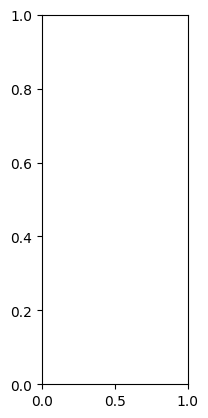

In [25]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask

for image_batch, mask_batch in test_ds.take(1):
    pred_mask = unet_1.predict(image_batch)
    for i in range(20):
        plt.subplot(1, 3, 1)
        plt.imshow((image_batch[i].numpy() * 255).astype("uint8"))
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(tf.squeeze(mask_batch[i]).numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        mask = create_mask(pred_mask[i])
        plt.imshow(tf.squeeze(mask).numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
        plt.show()

1/1 [==============================] - 1s 818ms/step


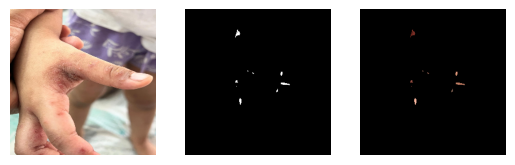

In [26]:
image_1 = keras.utils.load_img("datasets/Scabies Dataset/Scabies Images /Normal Scabies/547303cf-7ef3-4c4a-b237-f03918fab175.jpg")
image_1 = keras.utils.img_to_array(image_1)
image_1 = tf.image.resize(image_1, (IMG_HEIGHT, IMG_WIDTH))

pred = unet_1.predict(tf.expand_dims(image_1, axis=0))

mask = create_mask(pred[0])

plt.subplot(1, 3, 1)
img = image_1.numpy().astype("uint8")
plt.imshow(img)
plt.axis("off")
plt.subplot(1, 3, 2)
mask = tf.squeeze(mask).numpy().astype("uint8")
plt.imshow(mask, cmap="gray")
plt.axis("off")
expanded_mask = np.stack([mask] * 3, axis=-1)
sliced_image = expanded_mask * img
plt.subplot(1, 3, 3)
plt.imshow(sliced_image.astype("uint8"))
plt.axis("off")
plt.show()
